<a href="https://colab.research.google.com/github/1900690/eggplant-LAI/blob/main/LAI_calculation_app_for_eggplants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#gradio版のコードの全体

In [ ]:
#@title 動かすためにはgradioライブラリのインストールが必要
#@markdown gradioライブラリをインストール
!pip -q install gradio

In [ ]:
import cv2
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ====== リサイズユーティリティ ======
"""縦横比を保って画像を指定サイズ以下にリサイズする関数を定義"""
def resize_with_aspect_ratio(image, target_width=1108, target_height=1478):
    #入力画像の高さhと幅wを取得する
    h, w = image.shape[:2]
    #幅方向のスケール倍率（目標幅に合わせるための倍率）を計算。
    scale_w = target_width / w
    #高さ方向のスケール倍率（目標高さに合わせるための倍率）を計算。
    scale_h = target_height / h
    #幅・高さ両方を満たすため小さい方の倍率を選ぶ（縦横比維持）。
    scale = min(scale_w, scale_h)
    #新しい幅を整数化して計算。
    new_w = int(w * scale)
    #新しい高さを整数化して計算。
    new_h = int(h * scale)
    #OpenCVで実際にリサイズ（INTER_AREAは縮小時に適した補間）。
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    #リサイズ済み画像を返す。
    return resized

# ====== 画像解析ユーティリティ ======
"""HSV画像から自動で葉色のHue範囲を推定して返す関数を定義"""
def auto_leaf_range_from_hist(hsv, s_thresh=40, v_thresh=40):
    #彩度と明度が閾値を超えるピクセルだけを真にするブールマスクを作成
    mask_sv = (hsv[:, :, 1] > s_thresh) & (hsv[:, :, 2] > v_thresh)
    #条件を満たすピクセルのHue（色相）値のみ抽出
    hue_values = hsv[:, :, 0][mask_sv]
    #Hue値のヒストグラムを180の区画範囲で作成（hueは0～180まで）。
    hist_h, _ = np.histogram(hue_values, bins=180, range=(0, 180))
    #ヒストグラムのピークを検出。ピークの高さは最大値の30%以上を条件にしている。
    peaks, _ = find_peaks(hist_h, height=np.max(hist_h) * 0.3)
    #ピークが検出できなかった場合の条件分岐,ピーク無しならデフォルトの下限/上限（Hue:25〜90, S:40〜255, V:40〜255）を返す。
    if len(peaks) == 0:
        return np.array([25, 40, 40]), np.array([90, 255, 255])
    #検出したピークのうち最も小さいインデックス（最も左のピーク）を選ぶ
    main_peak = peaks[np.argmin(peaks)]
    #主ピークの左側に15の余裕を取りつつ下限を0未満にならないように制限。
    hue_min = max(0, main_peak - 15)
    #主ピークの右側に15の余裕を取りつつ上限を179を超えないように制限。
    hue_max = min(179, main_peak + 15)
    # 推定した下限・上限のHSV配列（Hue範囲とS/Vの固定閾値）を返す。
    return np.array([hue_min, 40, 40]), np.array([hue_max, 255, 255])

"""Hue値配列からヒストグラム画像を作る関数を定義"""
def generate_hue_histogram(hue_values, h_min, h_max):
    #与えられたHue値で180区画範囲のヒストグラムを作成。
    hist_h, _ = np.histogram(hue_values, bins=180, range=(0, 180))
    #matplotlibで図と軸を作成（幅6インチ×高さ3インチ）。
    fig, ax = plt.subplots(figsize=(6, 3))
    #ヒストグラムを線グラフとしてプロット（色は緑）。
    ax.plot(hist_h, color='g')
    #ヒストグラム上の選択範囲（h_min〜h_max）を半透明の黄色で塗る。
    ax.axvspan(h_min, h_max, color='y', alpha=0.3, label='selection range')
    #グラフタイトルを設定。
    ax.set_title('Hue Histogram')
    #凡例を表示
    ax.legend()
    #図のレンダリングを実行（キャンバスに描画）。
    fig.canvas.draw()
    #レンダラのRGBAバッファをNumPy配列に取り出し、画像として扱える形にする。
    hist_img = np.array(fig.canvas.renderer.buffer_rgba())
    # メモリ節約のために図を閉じる。
    plt.close(fig)
    #RGBA画像配列を返す
    return hist_img

"""入力画像とHSV閾値を受け取り、マスク生成・LAI計算・ヒストグラム出力を行う主要処理関数を定義。"""
def process_image(image, h_min, h_max, s_min, v_min):
    #まず画像を関数でリサイズして扱いやすくする。
    image = resize_with_aspect_ratio(image)
    #Gradioからの画像はRGBなので一度BGRに変換し、その後HSV色空間に変換してhsvを作る（OpenCVはBGR基準）。
    hsv = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2HSV)

    #マスク下限のHSV配列を作成。
    lower_bound = np.array([h_min, s_min, v_min])
    #マスク上限（Hueはh_max、S/Vは255固定の上限）を作成。
    upper_bound = np.array([h_max, 255, 255])
    #指定HSV範囲に入るピクセルを白(255)、それ以外を黒(0)にしたバイナリマスクを作成。
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    #参照画像（キャリブレーション）でのピクセル数を格納する定数:基準画像のピクセル数（picasosから抽出）
    reference_pixel_count = 1636516
    #参照時の1ピクセル当たりの面積（単位不記載）を格納する定数:基準画像の１ピクセル当たりの面積（picasosから抽出）
    area_per_pixel_ref = 2.170139

    #マスクで白（対象）になっているピクセル数を数える（葉のピクセル数）。
    leaf_pixels = int(np.count_nonzero(mask))
    #マスク全体のピクセル総数（画像サイズに相当）を取得。
    total_pixels = mask.size
    # LAIの値を計算する式：葉ピクセル数×ピクセル面積（百万でm2）に、画像サイズ比（total_pixels / reference_pixel_count）を掛けて補正している。
    LAI_rate = (leaf_pixels * area_per_pixel_ref) / 1_000_000 * (total_pixels / reference_pixel_count)
    #計算結果を短い文字列に整形（有効数字3桁相当の表示）。
    result_text = f"葉のLAI: {LAI_rate:.3g}"

    #彩度・明度が40より大きいピクセルのHue値を抽出（ヒストグラム作成用）。
    hue_values = hsv[:, :, 0][(hsv[:, :, 1] > 40) & (hsv[:, :, 2] > 40)]
    #上で抽出したHue値と現在のHue閾値でヒストグラム画像を生成。
    hist_img = generate_hue_histogram(hue_values, h_min, h_max)

    #計算したLAIの文字列,スクをGray→RGB変換して3チャンネル画像としたもの,作成したヒストグラム画像（RGBA配列）を返す。
    return (
        result_text,
        cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB),
        hist_img
    )

"""画像を受け取って、スライダーの初期値（自動検出されたHSV閾値）を返す関数を定義。"""
def init_sliders(image):
    #スライダー初期化関数内でもリサイズして一貫性を保つ。
    image = resize_with_aspect_ratio(image)
    #リサイズ済画像をRGB→BGR→HSVへ変換してhsvを作る。
    hsv = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2HSV)
    #先述の自動推定関数で下限と上限のHSV配列を得る。
    lower, upper = auto_leaf_range_from_hist(hsv)
    #スライダー用にHue下限・Hue上限・S下限・V下限を整数で返す（順序はh_min, h_max, s_min, v_min）。
    return int(lower[0]), int(upper[0]), int(lower[1]), int(lower[2])

# ====== Gradio UI ======
"""gradioで表示するためのブロック"""
with gr.Blocks(title="葉のLAI計算アプリ") as demo:
    gr.Markdown("## アップロードした画像からLAIを計算します。")

    with gr.Row():
        with gr.Column():
            img_input = gr.Image(type="numpy", label="画像をアップロード")

            btn_run = gr.Button("解析する", variant="primary")

            with gr.Accordion("うまく検出できない場合の微調整用", open=False):
                gr.Markdown("HSV色空間で値を調整する（抽出したHueヒストグラムの山をきれいに挟むように色相の上限と下限を調整してください）")
                h_min_slider = gr.Slider(0, 179, step=1, label="色相の下限")
                h_max_slider = gr.Slider(0, 179, step=1, label="色相の上限")
                s_min_slider = gr.Slider(0, 255, step=1, label="彩度の下限")
                v_min_slider = gr.Slider(0, 255, step=1, label="明度の下限")

            gr.Examples(
                examples=[
                    ["https://github.com/1900690/eggplant-LAI/releases/download/samle-images/kijun.JPG"],
                    ["https://github.com/1900690/eggplant-LAI/releases/download/samle-images/200.jpg"]
                ],
                inputs=img_input,
                label="画像例",
                cache_examples=False
            )

        with gr.Column():
            json_output = gr.Label(label="LAIの計算結果")
            mask_output = gr.Image(type="numpy", label="葉のマスク画像（葉が白、それ以外黒）")
            hist_output = gr.Image(type="numpy", label="抽出したHueヒストグラムの範囲")

    img_input.change(
        fn=init_sliders,
        inputs=img_input,
        outputs=[h_min_slider, h_max_slider, s_min_slider, v_min_slider]
    )

    btn_run.click(
        fn=process_image,
        inputs=[img_input, h_min_slider, h_max_slider, s_min_slider, v_min_slider],
        outputs=[json_output, mask_output, hist_output]
    )

    gr.Markdown(
        """
        ---
        <small>Copyright (c) 2025 risa iwase
        Released under the MIT license
        <a href="https://opensource.org/licenses/mit-license.php" target="_blank">https://opensource.org/licenses/mit-license.php</a></small>
        """
    )

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d28a3f2248d54cd7b4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#ラズパイ用にシンプルにすると


*   HSV閾値を数値で直接設定
*   マスク画像はPNGで保存
*   LAI値は標準出力に表示




In [ ]:
#@title Hue（色相）の範囲を手動で指定する場合の.pyファイルの中身は以下のコード
import cv2
import numpy as np

def calculate_lai(image_path, h_min, h_max, s_min, s_max, v_min, v_max, output_mask_path):
    # 画像読み込み（BGR形式）
    src = cv2.imread(image_path)
    if src is None:
        raise FileNotFoundError(f"画像が見つかりません: {image_path}")

    # HSV色空間に変換
    hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)

    # マスク生成
    lower = np.array([h_min, s_min, v_min])
    upper = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(hsv, lower, upper)

    # マスク画像保存
    cv2.imwrite(output_mask_path, mask)

    # LAI計算（簡易版：葉の面積率 × 定数係数）
    reference_pixel_count = 1636516
    area_per_pixel_ref = 2.170139
    total_pixels = mask.size
    leaf_pixels = cv2.countNonZero(mask)
    lai = (leaf_pixels * area_per_pixel_ref) / 1_000_000 * (total_pixels / reference_pixel_count)

    return lai

if __name__ == "__main__":
    # 入力設定（ラズパイではここを変更）
    image_path = "/content/kijun.JPG"#"input.jpg"
    output_mask_path = "/content/kijun.png"#"mask.png"

    # HSV閾値設定（例：緑色系）
    h_min, h_max = 35, 85
    s_min, s_max = 50, 255
    v_min, v_max = 50, 255

    lai_value = calculate_lai(image_path, h_min, h_max, s_min, s_max, v_min, v_max, output_mask_path)
    print(f"LAI値: {lai_value:.3f}")
    print(f"マスク画像を保存しました: {output_mask_path}")


LAI値: 2.785
マスク画像を保存しました: /content/kijun.png


In [ ]:
#@title Hue（色相）の範囲を自動で指定する場合の.pyファイルの中身は以下のコード
import cv2
import numpy as np
from scipy.signal import find_peaks

def auto_leaf_range_from_hist(hsv, s_thresh=40, v_thresh=40):
    """HSV画像から葉のHue範囲を自動推定"""
    # 彩度と明度が一定以上の画素を抽出
    mask_sv = (hsv[:, :, 1] > s_thresh) & (hsv[:, :, 2] > v_thresh)
    hue_values = hsv[:, :, 0][mask_sv]

    # Hueヒストグラム作成
    hist_h, _ = np.histogram(hue_values, bins=180, range=(0, 180))

    # ピーク検出
    peaks, _ = find_peaks(hist_h, height=np.max(hist_h) * 0.3)

    if len(peaks) == 0:
        # 葉が見つからなかった場合のデフォルト値（緑系）
        return np.array([25, 40, 40]), np.array([90, 255, 255])

    # 最も小さいHue位置のピークをメインとする
    main_peak = peaks[np.argmin(peaks)]
    hue_min = max(0, main_peak - 15)
    hue_max = min(179, main_peak + 15)

    return np.array([hue_min, 40, 40]), np.array([hue_max, 255, 255])

def calculate_lai(image_path, output_mask_path):
    # 画像読み込み（BGR形式）
    src = cv2.imread(image_path)
    if src is None:
        raise FileNotFoundError(f"画像が見つかりません: {image_path}")

    # HSV色空間に変換
    hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)

    # 自動で葉の範囲を推定
    lower, upper = auto_leaf_range_from_hist(hsv)

    # マスク生成
    mask = cv2.inRange(hsv, lower, upper)

    # マスク画像保存
    cv2.imwrite(output_mask_path, mask)

    # LAI計算（簡易版：葉の面積率 × 定数係数）
    reference_pixel_count = 1636516
    area_per_pixel_ref = 2.170139
    total_pixels = mask.size
    leaf_pixels = cv2.countNonZero(mask)
    lai = (leaf_pixels * area_per_pixel_ref) / 1_000_000 * (total_pixels / reference_pixel_count)

    return lai, lower, upper

if __name__ == "__main__":
    # 入力設定（ラズパイではここを変更）
    image_path = "/content/kijun.JPG"  # 入力画像
    output_mask_path = "/content/kijun.png"  # 出力マスク画像

    lai_value, lower_bound, upper_bound = calculate_lai(image_path, output_mask_path)

    print(f"推定されたHue範囲: {lower_bound[0]} ~ {upper_bound[0]}")
    print(f"LAI値: {lai_value:.3f}")
    print(f"マスク画像を保存しました: {output_mask_path}")

推定されたHue範囲: 22 ~ 52
LAI値: 2.891
マスク画像を保存しました: /content/kijun.png


#hugging face　デバック用

--- 解析結果 ---
設定 Hue範囲: 22 - 52
葉のピクセル数: 1331247 / 総ピクセル数: 1637624
計算されたLAI: 2.8909


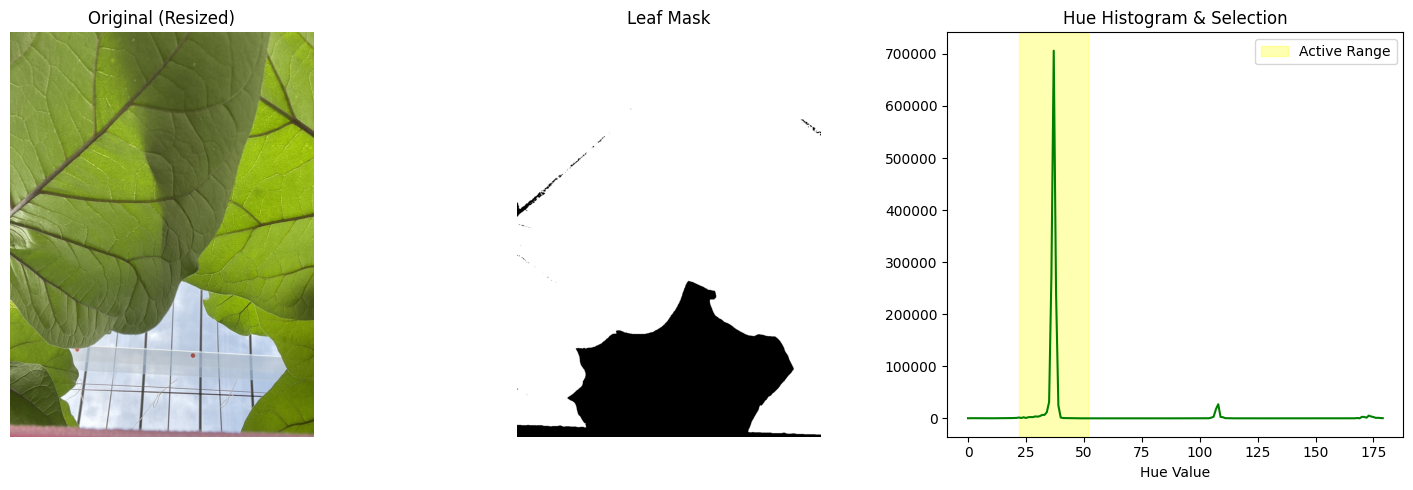

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import requests
from PIL import Image
from io import BytesIO

# ====== 設定（ここを書き換えてデバッグしてください） ======
# URLを指定するか、Colabにアップロードしたファイル名（'test.jpg'など）を指定してください
TARGET_IMAGE_PATH = "https://github.com/1900690/eggplant-LAI/releases/download/samle-images/kijun.JPG"

# 手動でHSVを微調整したい場合はここを書き換えます（Noneの場合は自動推定）
DEBUG_H_MIN = None
DEBUG_H_MAX = None

# ====== ユーティリティ関数（ロジックは元のまま） ======

def load_image(path):
    """URLまたはローカルパスから画像を読み込みRGBで返す"""
    if path.startswith('http'):
        response = requests.get(path)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        return np.array(img)
    else:
        img = cv2.imread(path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def resize_with_aspect_ratio(image, target_width=1108, target_height=1478):
    h, w = image.shape[:2]
    scale = min(target_width / w, target_height / h)
    new_w, new_h = int(w * scale), int(h * scale)
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

def auto_leaf_range_from_hist(hsv):
    mask_sv = (hsv[:, :, 1] > 40) & (hsv[:, :, 2] > 40)
    hue_values = hsv[:, :, 0][mask_sv]
    if len(hue_values) == 0:
        return 25, 90
    hist_h, _ = np.histogram(hue_values, bins=180, range=(0, 180))
    peaks, _ = find_peaks(hist_h, height=np.max(hist_h) * 0.3)
    if len(peaks) == 0:
        return 25, 90
    main_peak = peaks[np.argmin(peaks)]
    return max(0, main_peak - 15), min(179, main_peak + 15)

# ====== デバッグ実行メイン処理 ======

def debug_process(image_path):
    # 1. 画像読み込みとリサイズ
    original_img = load_image(image_path)
    img = resize_with_aspect_ratio(original_img)

    # 2. HSV変換
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # 3. パラメータ決定（自動または手動）
    auto_h_min, auto_h_max = auto_leaf_range_from_hist(hsv)
    h_min = DEBUG_H_MIN if DEBUG_H_MIN is not None else auto_h_min
    h_max = DEBUG_H_MAX if DEBUG_H_MAX is not None else auto_h_max
    s_min, v_min = 40, 40 # デフォルト値

    # 4. マスク処理とLAI計算
    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    leaf_pixels = int(np.count_nonzero(mask))
    total_pixels = mask.size
    reference_pixel_count = 1636516#★ここの固定値に問題あり？
    area_per_pixel_ref = 2.170139
    LAI_rate = (leaf_pixels * area_per_pixel_ref) / 1_000_000 * (total_pixels / reference_pixel_count)

    # 5. 結果表示（可視化）
    print(f"--- 解析結果 ---")
    print(f"設定 Hue範囲: {h_min} - {h_max}")
    print(f"葉のピクセル数: {leaf_pixels} / 総ピクセル数: {total_pixels}")
    print(f"計算されたLAI: {LAI_rate:.4f}")

    plt.figure(figsize=(15, 5))

    # 元画像
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original (Resized)")
    plt.axis('off')

    # マスク画像
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Leaf Mask")
    plt.axis('off')

    # ヒストグラム
    plt.subplot(1, 3, 3)
    hue_values = hsv[:, :, 0][(hsv[:, :, 1] > 40) & (hsv[:, :, 2] > 40)]
    hist_h, _ = np.histogram(hue_values, bins=180, range=(0, 180))
    plt.plot(hist_h, color='green')
    plt.axvspan(h_min, h_max, color='yellow', alpha=0.3, label='Active Range')
    plt.title("Hue Histogram & Selection")
    plt.xlabel("Hue Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 実行
debug_process(TARGET_IMAGE_PATH)

In [ ]:
def process_image_debug(image, h_min, h_max, s_min, v_min):
    # --- 前処理 ---
    image = resize_with_aspect_ratio(image)
    hsv = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2HSV)

    lower_bound = np.array([h_min, s_min, v_min])
    upper_bound = np.array([h_max, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # --- 定数 ---
    reference_pixel_count = 1636516
    area_per_pixel_ref = 2.170139

    # --- 計算ステップの分解 ---
    leaf_pixels = int(np.count_nonzero(mask))
    total_pixels = mask.size

    # 1. 現在の画像内での葉の総面積 (mm^2)
    raw_area_mm2 = leaf_pixels * area_per_pixel_ref

    # 2. 面積の単位変換 (mm^2 -> m^2)
    raw_area_m2 = raw_area_mm2 / 1_000_000

    # 3. 解像度補正係数 (基準画像と現在の画像のサイズ比)
    resolution_scale = total_pixels / reference_pixel_count

    # 4. 最終的な LAI 計算
    LAI_rate = raw_area_m2 * resolution_scale

    # --- コンソールへの可視化表示 ---
    print("="*50)
    print("【LAI 計算過程の可視化】")
    print(f"① 検出された葉の画素数　: {leaf_pixels:,} pixels")
    print(f"② 1画素あたりの基準面積 : {area_per_pixel_ref} mm²/pixel")
    print(f"③ 葉の合計面積 (mm²)    : {raw_area_mm2:,.2f} mm²  (① × ②)")
    print(f"④ 葉の合計面積 (m²)     : {raw_area_m2:.6f} m²  (③ ÷ 1,000,000)")
    print("-"*50)
    print(f"⑤ 現在の総画素数　　　 : {total_pixels:,} pixels")
    print(f"⑥ 基準の総画素数　　　 : {reference_pixel_count:,} pixels")
    print(f"⑦ 解像度補正係数　　　 : {resolution_scale:.4f}  (⑤ ÷ ⑥)")
    print("-"*50)
    print(f"■ 最終的な LAI 値 (④ × ⑦) : {LAI_rate:.6f}")
    print("="*50)

    return LAI_rate, mask

# テスト実行（画像がある場合）
# result, mask = process_image_debug(test_image, 25, 90, 40, 40)